# Dataviz coronavirus

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## Recupero dati

In [2]:
data = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")
data = data.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
data['data'] = data['data'].map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
data

,data,totale_casi
0,54,229
1,55,322
2,56,400
3,57,650
4,58,888
5,59,1128
6,60,1694
7,61,2036
8,62,2502
9,63,3089


In [9]:
def logistic_model(x,a,b,c):
    return c / (1 + np.exp(-(x - b) / a))

x = list(data.iloc[:,0])
y = list(data.iloc[:,1])
fit = curve_fit(
    logistic_model, 
    x, 
    y,
    p0=[2,100,20000]
)
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]

In [10]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [15]:
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c),b))
sol

150

In [33]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

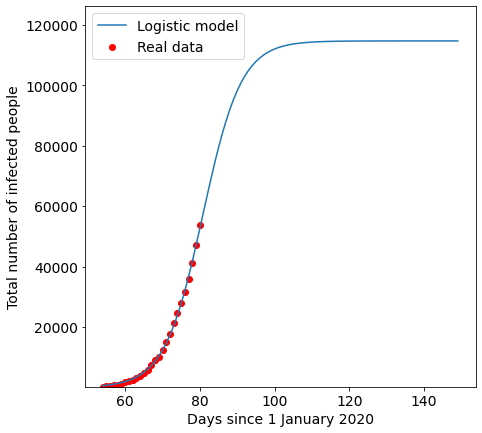

In [31]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x +pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x], label="Logistic model" )
# Predicted exponential curve
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()